#### Machine Learning Report: Match Result Classification
Predicting the winner of a tennis match is a good example of a binary classification problem. By providing a set of features to a classifier, new insights can be made both about the data and the problem at hand. In my case, I wish to better understand the statistics that matter to a player focused on winning the match. 

#### Prerequisite: Data Wrangling
I have come to learn that Data Wrangling never truly ends. Every additional feature requires some form of data manipulation. To simplify this notebook, I have moved all data wrangling steps into the Data Wrangling notebook. These include the career statistics, rolling statistics, head-to-head, and player winrates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Scikit-Learn
The scikit-learn library provides an almost overwhelming amount of resources for machine learning. It contains classifiers, regressors, clusterers, and metrics for model tuning. Many of these resources come with great defaults and documentation, so it has been an essential resource for my exploration into the subject. 

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest

The run_classifier function was extracted from my experimentation to avoid code duplication. This general purpose method can handle any classifier that provides a predict_proba method, such as a Random Forest Classifier, a Gradient Boosting Classifier, or even a Pipeline. It fits the classifier to the training data, plots the ROC curve for both the training and test datasets, and prints out the classification report for the test data predictions.

In [3]:
def run_classifier(columns, plot=True, vs=False):
    train_matches = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2021')]
    test_matches = matches[matches['tournament_date'] > '2021']
    
    X_train = train_matches[columns].dropna().drop('result_value', axis=1)
    y_train = train_matches[columns].dropna().result_value
    
    X_test = test_matches[columns].dropna().drop('result_value', axis=1)
    y_test = test_matches[columns].dropna().result_value

    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    if plot:
        plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
        plt.plot(fpr_train, tpr_train, label='Training Data')
        plt.plot(fpr, tpr, label='Testing Data')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
    
    if vs:
        higher_ranked = test_matches.dropna(subset=columns).ranking_points_diff > 0
        fpr_naive, tpr_naive, _ = roc_curve(y_test, higher_ranked.values)
        plt.plot(fpr_naive, tpr_naive, label='Favorites')

    if plot:
        plt.legend()
        plt.show()
     
    print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}')
    print(f'Test AUC: {roc_auc_score(y_test, y_pred)}')
    if vs:
        print(f'Favorite AUC: {roc_auc_score(y_test, higher_ranked)}')
        
    print(f'Test Accuracy: {accuracy_score(y_test, clf.predict(X_test))}')

#### Dataset
As always, the dataset I used can be found [here.](https://github.com/JeffSackmann/tennis_atp) For the purpose of classification, only the matches dataset will be required. It contains statistical records of every match played by top 100 players. 

In [4]:
matches = pd.read_pickle('../Resources/tennis_clean/atp_matches_full_feature.pkl').reset_index()

#### Feature Adjustment
Tennis match features come in two forms: opponent-dependent and opponent-independent. An example of an opponent-independent feature would be player height. An opponent-dependent feature adjusts the independent feature to take into account the corresponding opponent feature. Ranking Points Difference is an opponent-dependent feature that takes the difference of the two players' ranking points. Dependent features are more useful, as there can be large variance in the differences between opponent skill. 

## Step 1: Match Result Classifier

To train the initial model, I will use only matches from 2009-2018. The 2009 season marked a major revision of the ranking system, so statistics related to ranking points prior to this season may not be compatible with the new ranking system. Additionally, complete match statistics have been more frequently available in recent years. I will set aside the 2019 matches for additional testing later.

In [6]:
recent_matches = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2021')]
test_matches = matches[matches['tournament_date'] > '2021']

Before I continue, I want to look at the Logistic Regression plot of an important feature, the ranking points difference. This is what most people use to determine the favorite in a given match. In most cases, the higher ranked player is projected to win. As shown by the plot, not every match goes to the favorite. Even at a significant difference of 5000 points, the likelihood of victory is only 90%. Can we construct a model that accounts for potential upsets?

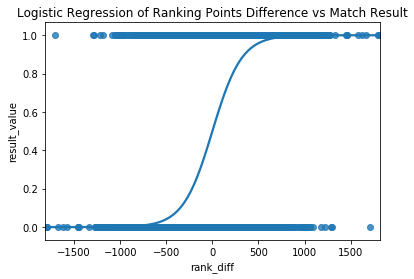

In [7]:
_ = sns.regplot(matches.rank_diff, matches.result_value, logistic=True, n_boot=10)
_ = plt.title('Logistic Regression of Ranking Points Difference vs Match Result')

I will use the accuracy of the higher ranked metric as the score to beat. In the test matches, the higher ranked player only wins 60% of the time. How much better can I do with the features available to me?

In [8]:
test_matches_results = test_matches.result_value 
higher_ranked = test_matches.rank_diff > 0
print(accuracy_score(test_matches_results, higher_ranked))

0.6314984709480123


Next, I'll  extract only the columns which pertain to the player. Columns such as "minutes" or "surface" affect both players and are not included. The target column is the "result_value" column, which represents a win as 1, and a loss as 0.

In [9]:
COLUMNS = ['aces', 'double_faults',
           'points', 'service_points', 'return_points', 
           'first_serves', 'second_serves', 'first_serves_won', 'second_serves_won',
           'break_points_faced', 'break_points_saved', 
           'opponent_break_points_faced', 'break_points_won',
           'first_serve_return_points_won', 'second_serve_return_points_won', 
           'opponent_service_points', 'opponent_first_serves',
           'service_points_won', 'return_points_won', 'points_won', 'result_value']

Dropping all rows with NaN values results in an acceptable loss. In many cases, imputing the value would lead to an inaccurate representation of the match, and would propagate errors onto later matches.

In [10]:
recent_matches = recent_matches.dropna()
recent_matches.shape

(56822, 167)

I will be using Scikit-Learn's GradientBoostingClassifier. Boosting is an ensemble algorithm that uses decision trees to classify data. Each tree aims to improve on older trees, "boosting" their performance as classifiers. It performs better than the Random Forest Classifier with default parameters, and does not overfit for the training data. Remarkably, the classifier has an accuracy of 94% out of the box. But should this be surprising? After all, we are providing the model with statistics that can only be calculated post-match. I have even removed the most obvious predictor, the percentage of points won.

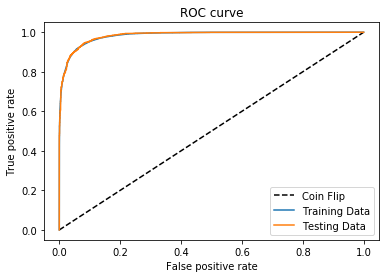

Train AUC: 0.9830943672332215
Test AUC: 0.983655721319836
Test Accuracy: 0.9295626576955425


In [11]:
scaler = MinMaxScaler()
gb = GradientBoostingClassifier()
clf = make_pipeline(scaler, gb)

run_classifier(COLUMNS)

The percentage of points won on serve and return stand out as the most important features. In fact, when the classifier is run with only these two features, the score remains near 94%. Without them, however, the remaining features are robust enough to retain a 94% accuracy. Note that the ranking points difference carries very little weight. Betting on the favorite seems like a losing strategy if you have a time machine.

In [12]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices[:11]]

[('break_points_won', 0.5363778392805513),
 ('break_points_faced', 0.3224056399968625),
 ('break_points_saved', 0.09105209203927689),
 ('service_points_won', 0.02215568068723401),
 ('points_won', 0.014572374106490078),
 ('points', 0.004462940843324134),
 ('aces', 0.0027622850756091554),
 ('return_points', 0.0014108617159052522),
 ('opponent_service_points', 0.0012102160780875732),
 ('opponent_first_serves', 0.0011043455026881171),
 ('second_serves', 0.0007760858080047663)]

## Step 2: Match Result Predictor

Can we train a classifier to predict the outcome of a match, using only data available prior to the match? This is a much trickier question, as it drastically limits the features we can use. Let's start with only the columns available in the matches dataset.

## Step 3: Career Data Acquisition

To give my predictive classifier more features, I'll need to generate career statistics for the players in the match.
I have done this using three pre-computed methods. RECENT_COLUMNS only uses match data from each player's last ten matches. These last ten matches are commonly seen on betting websites, and are intended to provide insight into whether a player is performing above or below their usual level.

PAST_YEAR_COLUMNS takes the average of all matches in the year prior to the match. This should give a longer-term view of a player's performance.

Finally, CAREER_COLUMNS averages all statistics prior to the match. Note that all of these feature sets are opponent-dependent. Unlike the post-match statistics, these features are not the reciprocal of the opponent's. To better represent them, the difference is taken to adjust the player's performance to the opponent's performance.

In [13]:
CAREER_COLUMNS = ['career_first_serve_percentage',
                  'career_first_serves_won_percentage',
                  'career_second_serves_won_percentage',
                  'career_service_points_won_percentage',
                  'career_break_points_saved_percentage',
                  'career_break_points_won_percentage',
                  'career_first_serve_return_points_won_percentage',
                  'career_second_serve_return_points_won_percentage',
                  'career_return_points_won_percentage',
                  'career_points_won_percentage',
                  'career_ace_rate',
                  'career_double_fault_rate']

CAREER_COLUMNS += [column + '_opponent' for column in CAREER_COLUMNS]

To determine which metric performs best, I'll test all three feature sets separately. RECENT_COLUMNS outperforms the favorite-only metric, but not by much. This is surprising, as momentum and hot streaks have been long thought of as a significant factor in future performance.

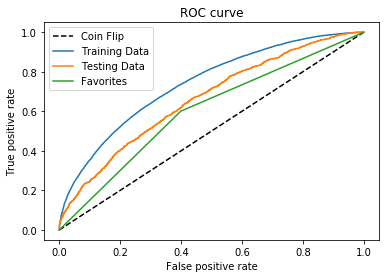

Train AUC: 0.7393062474046377
Test AUC: 0.6615093253902291
Favorite AUC: 0.6007148864592095
Test Accuracy: 0.6087047939444912


In [14]:
run_classifier(CAREER_COLUMNS + ['result_value'], vs=True)

The "recent points won percentage" feature overshadows the others. This feature is the best estimation for the degree by which a player has won or lost their recent matches. A high value suggests easy wins, and a low value suggests losses or struggles winning matches.

In [15]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(CAREER_COLUMNS[i], importances[i]) for i in indices[:5]]

[('career_points_won_percentage', 0.40273561204902975),
 ('career_points_won_percentage_opponent', 0.39288856044839804),
 ('career_service_points_won_percentage_opponent', 0.023362085780221656),
 ('career_service_points_won_percentage', 0.021294214881551938),
 ('career_ace_rate_opponent', 0.012563470414454873)]

The PAST_YEAR feature set performs even worse, with an accuracy of 60%. Perhaps taking more matches into account reduces their potency as a predictor of future performance.

In [16]:
EWMA_10_COLUMNS = ['ewma_10_first_serve_percentage',
                   'ewma_10_first_serves_won_percentage',
                   'ewma_10_second_serves_won_percentage',
                   'ewma_10_service_points_won_percentage',
                   'ewma_10_break_points_saved_percentage',
                   'ewma_10_break_points_won_percentage',
                   'ewma_10_first_serve_return_points_won_percentage',
                   'ewma_10_second_serve_return_points_won_percentage',
                   'ewma_10_return_points_won_percentage',
                   'ewma_10_points_won_percentage',
                   'ewma_10_ace_rate',
                   'ewma_10_double_fault_rate']

EWMA_10_COLUMNS += [column + '_opponent' for column in EWMA_10_COLUMNS]

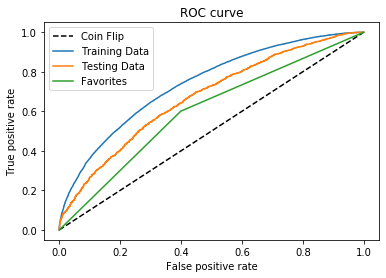

Train AUC: 0.7399676143788267
Test AUC: 0.6719449948044911
Favorite AUC: 0.6007148864592095
Test Accuracy: 0.6200588730025232


In [17]:
run_classifier(EWMA_10_COLUMNS + ['result_value'], vs=True)

"Points won percentage" rates ahead of the other features.

In [18]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(EWMA_10_COLUMNS[i], importances[i]) for i in indices[:5]]

[('ewma_10_points_won_percentage', 0.4366942735121369),
 ('ewma_10_points_won_percentage_opponent', 0.4256924333847968),
 ('ewma_10_service_points_won_percentage_opponent', 0.028903433688645157),
 ('ewma_10_service_points_won_percentage', 0.027939425620160916),
 ('ewma_10_ace_rate', 0.008277936732044194)]

Using career statistics results in a performance boost. Without knowing the current rank difference, this classifier performs better than any of the previous models. Surprisingly, looking at recent results introduces more bias than looking at the entire career.

In [19]:
EWMA_50_COLUMNS = ['ewma_50_first_serve_percentage',
                   'ewma_50_first_serves_won_percentage',
                   'ewma_50_second_serves_won_percentage',
                   'ewma_50_service_points_won_percentage',
                   'ewma_50_break_points_saved_percentage',
                   'ewma_50_break_points_won_percentage',
                   'ewma_50_first_serve_return_points_won_percentage',
                   'ewma_50_second_serve_return_points_won_percentage',
                   'ewma_50_return_points_won_percentage',
                   'ewma_50_points_won_percentage',
                   'ewma_50_ace_rate',
                   'ewma_50_double_fault_rate']

EWMA_50_COLUMNS += [column + '_opponent' for column in EWMA_50_COLUMNS]

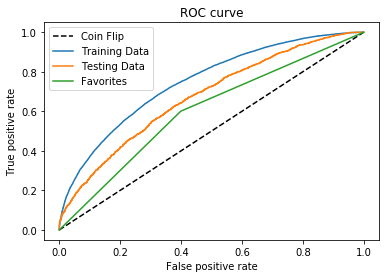

Train AUC: 0.7479367603830768
Test AUC: 0.6739801382309523
Favorite AUC: 0.6007148864592095
Test Accuracy: 0.6232127838519764


In [20]:
run_classifier(EWMA_50_COLUMNS + ['result_value'], vs=True)

In [21]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(EWMA_50_COLUMNS[i], importances[i]) for i in indices[:5]]

[('ewma_50_points_won_percentage_opponent', 0.437499850079431),
 ('ewma_50_points_won_percentage', 0.4278507794876148),
 ('ewma_50_service_points_won_percentage', 0.02480230161129275),
 ('ewma_50_service_points_won_percentage_opponent', 0.019283349785728588),
 ('ewma_50_break_points_saved_percentage', 0.00810368528368449)]

In closing, I would like to propose some methods to improve the model that I may explore in the future:

1. Factoring in the quality of opponents. Not all wins carry the same weight. A win versus a higher-ranked opponent may indicate either that the player played well or that the opponent played worse than their rank would suggest. In essence, an ELO system like the one used in chess.

2. Exponential decay of recent perfomance. Tracking the last ten matches may not mean much for a player who has been injured, or for matches played at the beginning of the year after a month-long offseason.

3. Including only performance-dependent features. By looking only at statistics like first-serve percentage, number of aces, etc., more insight could be gained from the feature extraction of the model.

Individual players have been reported to be working with analytics firms in recent years. However, the price of working with these firms is steep, and may not be feasible for lower-ranked players. Having a publicly-available resource for advanced analytics may require a community effort from tennis fans. I can only hope that one day tennis fans talk about silly acronyms like WHIP with a straight face just as they do in baseball.

### Bonus: A Shallow Dive into Deep Learning

The Deep Learning notebook details the process used to attain a small performance gain from the machine learning model. The Deep Learning Neural Network (with only one hidden layer, so not that deep) has an accuracy of 66.5%, predicting nearly 2/3rds of all matches correctly in the test set. This only increases my belief that to improve on my predictive model, better features are needed.

In [22]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

best_model = load_model('best_model.h5')

train_matches = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2019')]
test_matches = matches[matches['tournament_date'] > '2019']

X_train = train_matches[COLUMNS].dropna().drop('result_value', axis=1)
y_train = train_matches[COLUMNS].dropna().result_value

X_test = test_matches[COLUMNS].dropna().drop('result_value', axis=1)
y_test = test_matches[COLUMNS].dropna().result_value

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_pred_nn = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_nn)

y_pred_gb = clf.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
plt.plot(fpr, tpr, label='Testing Data NN')
plt.plot(fpr_gb, tpr_gb, label='Testing Data GB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Neural Network vs GradientBoosting')

higher_ranked = test_matches.dropna(subset=COLUMNS).ranking_points_diff > 0
fpr_naive, tpr_naive, _ = roc_curve(y_test, higher_ranked.values)
plt.plot(fpr_naive, tpr_naive, label='Favorites')

plt.legend()
plt.show()

print(f'NN AUC: {roc_auc_score(y_test, y_pred_nn)}')
print(f'GB AUC: {roc_auc_score(y_test, y_pred_gb)}')
print(f'Favorite AUC: {roc_auc_score(y_test, higher_ranked)}\n')

print(f'Test Accuracy NN: {accuracy_score(y_test, best_model.predict_classes(X_test_scaled))}')
print(f'Test Accuracy GB: {accuracy_score(y_test, clf.predict(X_test))}')
print(f'Favorite Accuracy: {accuracy_score(y_test, higher_ranked)}')

OSError: SavedModel file does not exist at: best_model.h5/{saved_model.pbtxt|saved_model.pb}